In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, BatchNormalization, Conv1D, Layer, Activation, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/PAMAP2_Dataset/Sensor_Fusion_PAMAPS_withNames.csv")

label = LabelEncoder()
data['Labels'] = label.fit_transform(data['Activity'])
data.head()


,timestamp,activityID,acc_x,acc_y,acc_z,acc2_x,acc2_y,acc2_z,gry_x,gry_y,gry_z,mag_x,mag_y,mag_z,Activity,Labels
0,37.66,1,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,Laying,1
1,37.67,1,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,Laying,1
2,37.68,1,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,Laying,1
3,37.69,1,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,Laying,1
4,37.70,1,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,Laying,1


In [ ]:
label.classes_

array(['Downstairs', 'Laying', 'Running', 'Sitting', 'Standing',
       'Upstairs', 'Walking'], dtype=object)

In [ ]:
X = data[['acc_x', "acc_y", 'acc_z', 'acc2_x', "acc2_y", "acc2_z", 'gry_x', 'gry_y', 'gry_z', 'mag_x',"mag_y",'mag_z']]
Y = data['Labels']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
Scaled_X = pd.DataFrame(X, columns=['acc_x', "acc_y", 'acc_z', 'acc2_x', "acc2_y", "acc2_z", 'gry_x', 'gry_y', 'gry_z', 'mag_x',"mag_y",'mag_z'])
Scaled_X["Labels"] = Y.values
Scaled_X.head()

,acc_x,acc_y,acc_z,acc2_x,acc2_y,acc2_z,gry_x,gry_y,gry_z,mag_x,mag_y,mag_z,Labels
0,0.004406,0.685463,1.015330,0.007024,0.755230,1.067490,-0.004336,0.035772,-0.002214,0.393029,-2.491760,-0.596782,1
1,0.011703,0.617066,1.044984,0.009662,0.706420,1.070722,-0.126942,0.022868,-0.001455,0.411719,-2.492838,-0.629396,1
2,0.011602,0.557219,1.059845,0.009262,0.648600,1.070939,-0.175798,0.007656,0.003441,0.396565,-2.469580,-0.580461,1
3,0.004663,0.557360,1.074164,0.004554,0.599863,1.089477,-0.142511,0.016016,0.009364,0.421594,-2.471125,-0.617208,1
4,0.012569,0.570325,1.110639,0.003122,0.598077,1.104778,-0.052224,-0.023847,0.005212,0.399468,-2.460422,-0.600632,1


In [ ]:
import scipy.stats as stats

In [ ]:
frame_size = 100
overlap_size =10

In [ ]:
from re import M
def get_frames(data, frame_size, overlap_size):
  frames = []
  labels = []
  n_features = 12
  for i in range(0, len(data) - frame_size, overlap_size):
    x = data["acc_x"].values[i: i + frame_size]
    y = data["acc_y"].values[i: i + frame_size]
    z = data["acc_z"].values[i: i + frame_size]
    m = data["acc2_x"].values[i: i + frame_size]
    n = data["acc2_y"].values[i: i + frame_size]
    o = data["acc2_z"].values[i: i + frame_size]
    x2 = data["gry_x"].values[i: i + frame_size]
    y2 = data["gry_y"].values[i: i + frame_size]
    z2= data["gry_z"].values[i: i + frame_size]
    m2 = data["mag_x"].values[i: i + frame_size]
    n2 = data["mag_y"].values[i: i + frame_size]
    o2 = data["mag_z"].values[i: i + frame_size]


    label = stats.mode(data["Labels"][i: i + frame_size])[0]
    frames.append([x, y, z, m, n, o, x2, y2, z2, m2, n2, o2])
    labels.append(label)
  frames = np.array(frames).reshape(-1, frame_size, n_features)
  labels = np.array(labels)
  return frames, labels


In [ ]:
X_data, Y_data = get_frames(Scaled_X, frame_size, overlap_size)

In [ ]:
X_data.shape, Y_data.shape

((111990, 100, 12), (111990,))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.75, random_state=42)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((89592, 100, 12), (89592,), (16799, 100, 12), (16799,))

In [ ]:
import tensorflow as tf
from keras.layers import Layer, Conv1D, BatchNormalization, Activation, LSTM, Multiply, Input, Dense, Bidirectional, Dropout
from keras.models import Model

class TemporalAttentionLayer(Layer):
    def __init__(self):
        super(TemporalAttentionLayer, self).__init__()
        self.conv = Conv1D(filters=1, kernel_size=5, strides=1, padding='same', use_bias=False)
        self.bn = BatchNormalization(epsilon=1e-5, momentum=0.01, trainable=True)
        self.activation = Activation("sigmoid")
        self.lstm = LSTM(n_features, return_sequences=True)

    def call(self, x):
        # Temporal Attention Computation
        x_compress = channelPoolingTemporal(x)


        # Define Conv1D dynamically inside call()
        x_out = self.conv(x_compress)
        x_out = self.bn(x_out)
        attention_weights = self.activation(x_out)

        # Ensure attention_weights has the same shape as x for multiplication
        output_tensor = Multiply()([x, attention_weights])

        # LSTM Computation
        lstm_out = self.lstm(x)

        # Residual Connection
        residual_output = tf.add(output_tensor, lstm_out)

        return residual_output

def channelPoolingTemporal(x):
    max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    mean_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
    return tf.concat([max_pool, mean_pool], axis=-1)

# Define local model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (sequence_length, n_features)
feature_1 = Conv1D(filters=n_features, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
attention_output = TemporalAttentionLayer()(feature_1)

# # Add LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True))(attention_output)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)

# Add Dense layers
x = Dense(64, LeakyReLU(negative_slope= 0.1),kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(32, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(16, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(8, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

outputs = Dense(7, activation='softmax')(x)


local_model = Model(inputs=inputs, outputs=outputs)
local_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 12)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 100, 12)             │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_layer             │ (None, 100, 12)             │           1,214 │
│ (TemporalAttentionLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 512)            │         550,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,384,357 (5.28 MB)

 Trainable params: 1,384,355 (5.28 MB)

 Non-trainable params: 2 (8.00 B)

In [ ]:
# Compile the model
local_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Adjust loss for your task

# Fit the model
history = local_model.fit(X_train, Y_train, epochs=40, batch_size=128, validation_data=(X_val, Y_val), verbose=1)


Epoch 1/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 62s 73ms/step - accuracy: 0.6101 - loss: 1.7356 - val_accuracy: 0.8660 - val_loss: 0.6311
Epoch 2/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.8717 - loss: 0.6153 - val_accuracy: 0.9068 - val_loss: 0.4834
Epoch 3/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 74ms/step - accuracy: 0.9108 - loss: 0.4712 - val_accuracy: 0.9277 - val_loss: 0.3982
Epoch 4/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.9300 - loss: 0.3979 - val_accuracy: 0.9364 - val_loss: 0.3632
Epoch 5/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 74ms/step - accuracy: 0.9462 - loss: 0.3342 - val_accuracy: 0.9484 - val_loss: 0.3097
Epoch 6/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 74ms/step - accuracy: 0.9538 - loss: 0.2965 - val_accuracy: 0.9498 - val_loss: 0.2957
Epoch 7/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 74ms/step - accuracy: 0.9625 - loss: 0.2589 - val_accuracy: 0.9612 - val_loss: 0.2574
Epoch 8/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.9642 - loss: 0.2449 - 

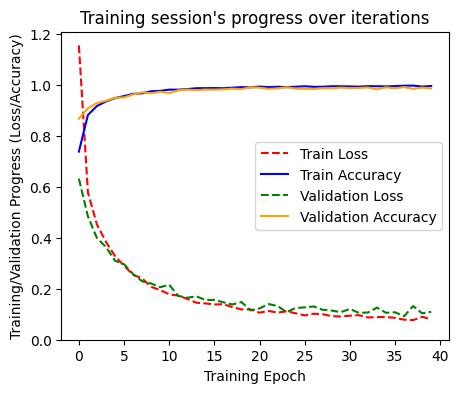

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(np.array(history.history['loss']), "r--", label = "Train Loss")
plt.plot(np.array(history.history['accuracy']), "b-", label = "Train Accuracy")
plt.plot(np.array(history.history['val_loss']), "g--", label = "Validation Loss")
plt.plot(np.array(history.history['val_accuracy']), "orange", label = "Validation Accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='center right')
plt.ylabel('Training/Validation Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# Evaluate the model
loss, local_accuracy = local_model.evaluate(X_test, Y_test)
print(f'Loss: {loss}, Accuracy: {local_accuracy}')

525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9847 - loss: 0.1057
Loss: 0.10847248136997223, Accuracy: 0.9845824241638184


525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step


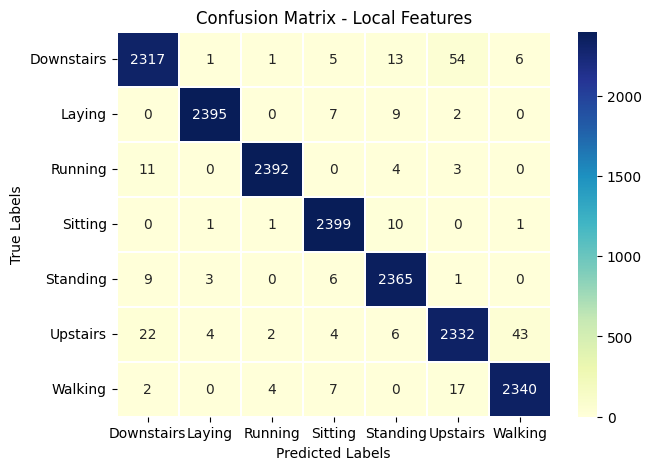

In [ ]:
# Ensure Y_test is a 1D array
max_test = Y_test if Y_test.ndim == 1 else np.argmax(Y_test, axis=1)

# Get model predictions
max_predictions = np.argmax(local_model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(max_test, max_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths = 0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Local Features')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D, BatchNormalization, Activation, LSTM, Multiply, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


class TemporalAttentionLayer(Layer):
    def __init__(self):
        super(TemporalAttentionLayer, self).__init__()
        self.conv1d = Conv1D(filters=n_features, kernel_size=5, strides=1, padding='same', use_bias=False)
        self.bn = BatchNormalization(epsilon=1e-5, momentum=0.01, trainable=True)
        self.activation = Activation("sigmoid")
        self.lstm = LSTM(n_features, return_sequences=True)

    def call(self, x):
        # Extract energy features per axis
        energy_features = compute_energy_features_per_axis(x)

        attention_input = self.conv1d(energy_features)
        attention_input = self.bn(attention_input)
        attention_weights = self.activation(attention_input)

        # Apply attention weights to original input
        output_tensor = Multiply()([x, attention_weights])

        # LSTM Computation
        lstm_out = self.lstm(x)

        # Residual Connection
        residual_output = tf.add(output_tensor, lstm_out)

        return residual_output

In [ ]:
# Define local model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (sequence_length, n_features)
attention_output = TemporalAttentionLayer()(inputs)

# # Add LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True))(attention_output)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)

# Add Dense layers
x = Dense(64, LeakyReLU(negative_slope= 0.1),kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(32, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(16, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(8, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

outputs = Dense(7, activation='softmax')(x)

global_model = Model(inputs=inputs, outputs=outputs)
global_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 12)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_layer_1           │ (None, 100, 12)             │           2,688 │
│ (TemporalAttentionLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 512)            │         550,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,385,399 (5.28 MB)

 Trainable params: 1,385,375 (5.28 MB)

 Non-trainable params: 24 (96.00 B)

In [ ]:
# Compile the model
global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Adjust loss for your task

# Fit the model
history = global_model.fit(X_train, Y_train, epochs=40, batch_size=128, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 60s 75ms/step - accuracy: 0.5741 - loss: 1.7819 - val_accuracy: 0.8760 - val_loss: 0.6246
Epoch 2/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.8679 - loss: 0.6268 - val_accuracy: 0.8944 - val_loss: 0.5005
Epoch 3/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.9061 - loss: 0.4850 - val_accuracy: 0.9173 - val_loss: 0.4313
Epoch 4/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.9218 - loss: 0.4177 - val_accuracy: 0.9427 - val_loss: 0.3422
Epoch 5/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 74ms/step - accuracy: 0.9394 - loss: 0.3520 - val_accuracy: 0.9359 - val_loss: 0.3555
Epoch 6/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 74ms/step - accuracy: 0.9467 - loss: 0.3164 - val_accuracy: 0.9587 - val_loss: 0.2774
Epoch 7/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 74ms/step - accuracy: 0.9568 - loss: 0.2794 - val_accuracy: 0.9578 - val_loss: 0.2745
Epoch 8/40
700/700 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.9636 - loss: 0.2475 - 

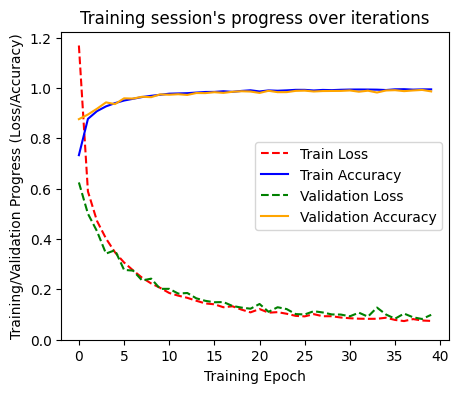

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(np.array(history.history['loss']), "r--", label = "Train Loss")
plt.plot(np.array(history.history['accuracy']), "b-", label = "Train Accuracy")
plt.plot(np.array(history.history['val_loss']), "g--", label = "Validation Loss")
plt.plot(np.array(history.history['val_accuracy']), "orange", label = "Validation Accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='center right')
plt.ylabel('Training/Validation Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# Evaluate the model
loss, global_accuracy = global_model.evaluate(X_test, Y_test)
print(f'Loss: {loss}, Accuracy: {global_accuracy}')

525/525 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9841 - loss: 0.1081
Loss: 0.11101990938186646, Accuracy: 0.9824989438056946


525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step


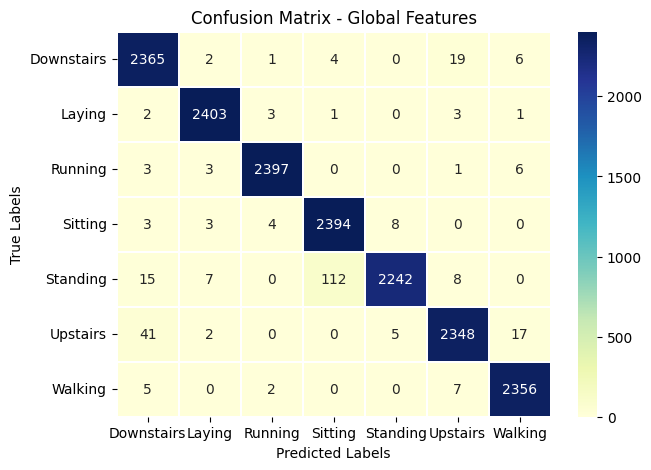

In [ ]:
# Ensure Y_test is a 1D array
max_test = Y_test if Y_test.ndim == 1 else np.argmax(Y_test, axis=1)

# Get model predictions
max_predictions = np.argmax(global_model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(max_test, max_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths = 0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Global Features')
plt.show()

525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
Using Weights: Energy Model = 0.50, Local Model = 0.50
Weighted Fusion Accuracy: 0.9932


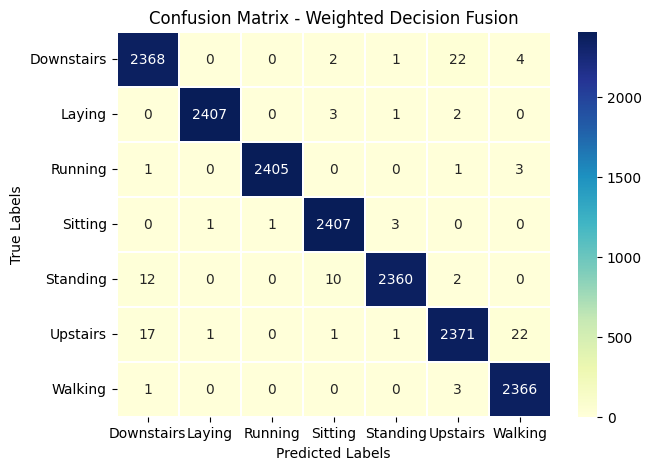

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

def weighted_fusion(energy_model, local_model, X_test, val_acc_global, val_acc_local):


    # Get softmax probabilities from both models
    prob_energy = energy_model.predict(X_test)
    prob_local = local_model.predict(X_test)

    # Compute dynamic weights (normalize validation accuracies)
    total_acc = val_acc_global + val_acc_local
    weight_global = val_acc_global / total_acc
    weight_local = val_acc_local / total_acc

    print(f"Using Weights: Energy Model = {weight_global:.2f}, Local Model = {weight_local:.2f}")

    # Compute weighted probabilities
    weighted_probs = (weight_global * prob_energy) + (weight_local * prob_local)

    # Get final predictions (argmax over weighted sum)
    final_predictions = np.argmax(weighted_probs, axis=1)

    return final_predictions

# Compute final weighted fusion predictions
combined_predictions = weighted_fusion(global_model, local_model, X_test, global_accuracy, local_accuracy)

# Compute accuracy
fusion_accuracy = accuracy_score(Y_test, combined_predictions)
print(f'Weighted Fusion Accuracy: {fusion_accuracy:.4f}')

# Compute confusion matrix
cm = confusion_matrix(Y_test, combined_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Weighted Decision Fusion')
plt.show()
